# Impact of Manual Labels

In this notebook, we study whether adding the manual anomaly labels is useful to an autoencoder model. Removing other potential anoamlies should keep any unreported crashes out of the training set. Therefore, the autoencoder should fail to reconstruct anomalous data. 

In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import GATAE
from parameters import GATAEParameters, TrainingParameters
from datautils import get_morning_data, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gatae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Time Series Sequencing

In [2]:
def sequence_gatae(data, timesteps, hide_anomalies=True):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially

        node_data = np.concatenate(data_t[::-1])
        pyg_data = Data(x=torch.tensor(node_data, dtype=torch.float32), edge_index=relational_edges, edge_attr=torch.tensor(relations, dtype=torch.long))
        
        # curr_data = data_t[-1]
        curr_data = data_t[0]
        
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append([pyg_data, curr_graph])

    return sequence, kept_indices

### Loading Hyperparameters

In [3]:
optimal_hyperparams = load_best_parameters('gat')

In [4]:
optimal_hyperparams

{'dropout': 0.091734046321678,
 'epochs': 6,
 'gcn_hidden_dim': 128,
 'latent_dim': 256,
 'learning_rate': 0.0003592972306504555,
 'num_heads': 4,
 'num_layers': 1,
 'timesteps': 2}

In [5]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [6]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=optimal_hyperparams['timesteps'],
    n_epochs=1
)

In [7]:
train_data, test_data, _ = get_full_data()
train_data = normalize_data(train_data)
train_data = label_anomalies(train_data)
train_sequence, kept_train_indices = sequence_gatae(train_data, training_params.timesteps)

100%|██████████| 13438/13438 [02:08<00:00, 104.22it/s]


In [8]:
hyperparams = GATAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_layers=optimal_hyperparams['num_layers'],
    num_heads=optimal_hyperparams['num_heads']
)

In [9]:
ae = GATAE(hyperparams)

In [10]:
ae(train_sequence[0][0]).shape

torch.Size([196, 3])

### Model Training or Loading

In [11]:
using_pretrained = False

In [12]:
if not using_pretrained:
    ae, losses = train_gatae(gataeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, 'nomanual_gat')
else:
    ae = load_model(GATAE, hyperparams, 'nomanual_gat')

In [13]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [14]:
thresh = compute_anomaly_threshold_rstae(train_sequence, ae, mse_weights, 'max')

100%|██████████| 6408/6408 [00:54<00:00, 118.11it/s]


### Loading Test Data

In [15]:
_, df_test_data, _ = get_full_data()

In [16]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gatae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4798/4798 [00:14<00:00, 320.20it/s]


In [17]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [18]:
np.mean(test_errors)

0.012466615

In [19]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/home/austinc/projects/traffic-anomaly/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/home/austinc/projects/traffic-anomaly/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [20]:
thresholds = find_thresholds(thresh, test_errors, anomaly_labels)
offset_10 = find_percent(thresholds, 10)

100%|██████████| 1000/1000 [01:07<00:00, 14.78it/s]


### Compute FPR / Crash Detection Delay Tradeoff

In [21]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 98/98 [00:00<00:00, 98.80it/s]


In [22]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/nomanual_gatae_fp_delay.csv')

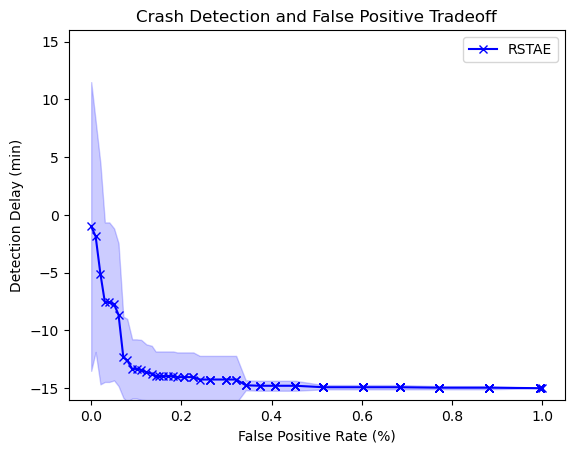

In [23]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [24]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [01:07<00:00, 14.85it/s]

FPR 1% gives mean delay of -1.8571428571428572 +/- 10.009689183537139 while missing 0.41666666666666663%.
FPR 2.5% gives mean delay of -6.111111111111111 +/- 8.805862244922027 while missing 0.25%.
FPR 5% gives mean delay of -7.75 +/- 6.577423507727019 while missing 0.16666666666666663%.
FPR 10% gives mean delay of -13.333333333333334 +/- 2.5603819159562025 while missing 0.0%.
FPR 20% gives mean delay of -14.041666666666666 +/- 2.1355945047899163 while missing 0.0%.


### Compute AUC

In [25]:
calculate_auc(test_errors, anomaly_labels)

0.6822365294587518

### Compute Detection Delay Histogram on Full Dataset

In [26]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [27]:
full_sequence, kept_full_indices = sequence_gatae(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/18238 [00:00<?, ?it/s]

100%|██████████| 18238/18238 [04:32<00:00, 66.93it/s]


In [28]:
full_errors, _, _ = test_rstae(full_sequence, mse_weights, ae)

In [29]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

/home/austinc/projects/traffic-anomaly/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [30]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s]


In [31]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


In [32]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

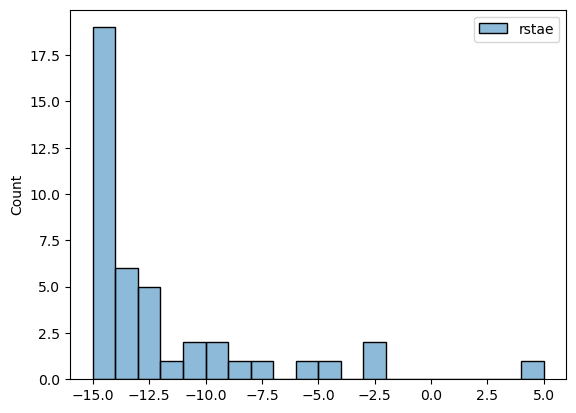

In [33]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='rstae')
plt.legend()

In [34]:
np.save('./saved_results/nomanual_gatae10delays.npy', np.array(delay)/2)

In [35]:
_, df_clean_test_data, _ = get_full_data()

In [36]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_gatae(clean_test_data, training_params.timesteps, hide_anomalies=True)

100%|██████████| 4798/4798 [00:11<00:00, 416.97it/s]


In [37]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_rstae(clean_test_data, mse_weights, ae)

In [38]:
np.mean(clean_test_errors)

0.008966662

### Case Study

In [39]:
_, df_test_data, _ = get_full_data()

In [40]:
df_test_data = df_test_data[df_test_data['day']==10]

In [41]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gatae(test_data, training_params.timesteps, hide_anomalies=False)

  5%|▌         | 48/958 [00:00<00:01, 474.37it/s]

100%|██████████| 958/958 [00:02<00:00, 431.53it/s]


In [42]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [43]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/home/austinc/projects/traffic-anomaly/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/home/austinc/projects/traffic-anomaly/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [44]:
anomalies_10 = threshold_anomalies(thresh+offset_10, test_errors)

In [45]:
data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [46]:
data.to_csv('./saved_results/nomanual_anom_results_gat.csv')

In [47]:
df_test_data[df_test_data['crash_record']==1]

,day,milemarker,human_label,crash_record,unix_time,speed,occ,volume
343441,10,53.3,0,1,1697023470,63.153616,16.0,15.0
1284241,10,53.3,0,1,1697023470,61.369748,15.0,11.0
2225041,10,53.3,0,1,1697023470,58.138872,15.0,14.0
3165841,10,53.3,0,1,1697023470,56.912889,16.0,15.0
343442,10,53.6,0,1,1697023470,62.593691,13.0,14.0
...,...,...,...,...,...,...,...,...
3165888,10,69.8,0,1,1697023470,70.568478,1.0,2.0
343489,10,70.1,0,1,1697023470,77.669218,3.0,5.0
1284289,10,70.1,0,1,1697023470,73.904376,5.0,8.0
2225089,10,70.1,0,1,1697023470,71.009237,2.0,4.0


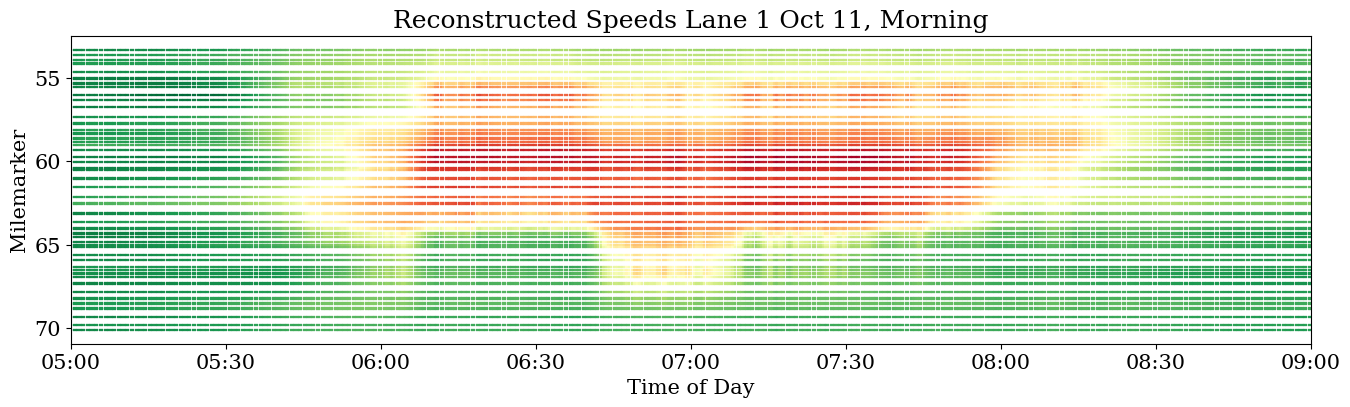

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/nomanual_anom_results_gat.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index']*30+ 14400, unit='s') 
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed'].values),marker='s',s=1, cmap='viridis')
# filtered_lane = lane[lane['Anomaly'] == 1]

# plt.scatter(filtered_lane['Time Index'], filtered_lane['Milemarker'].values,
#             c=filtered_lane['Anomaly'].values, marker='s', s=1, cmap='RdYlGn', label='Nominal', alpha=0.5)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Oct 11, Morning")
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.xlim(start_time, end_time)
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

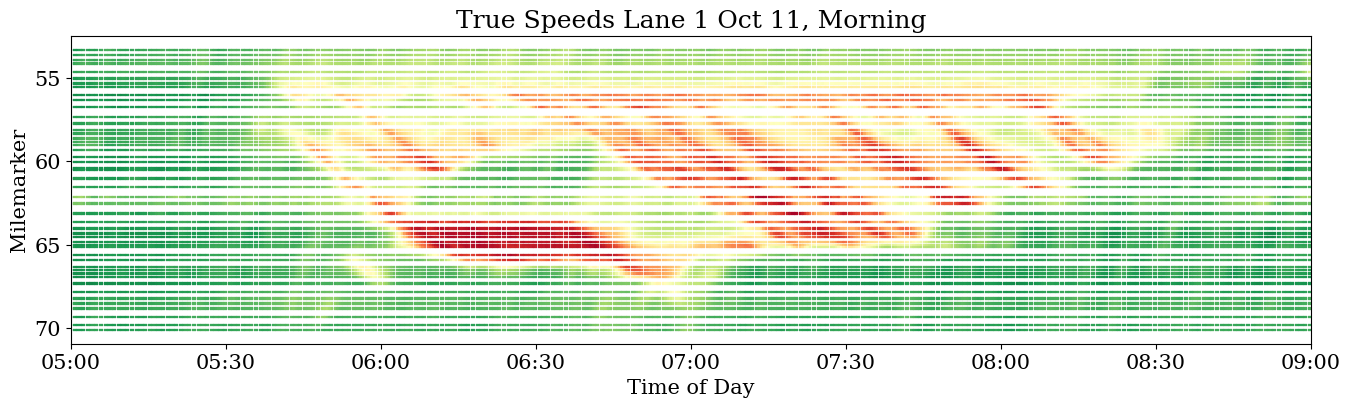

In [49]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'] , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Oct 11, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
# plt.xlim(30000, 90000)

plt.show()

In [50]:
time_anomalies = np.any(anomalies_10==1, axis=1)

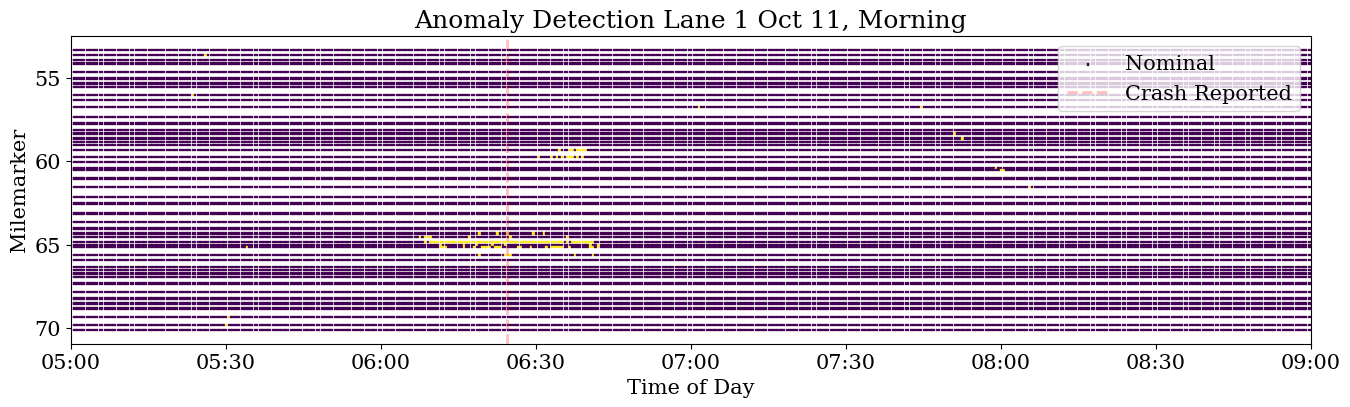

In [51]:
crash_reported = np.where(np.array(df_test_data['crash_record']==1))[0][0] / 196
crash_reported =  pd.to_datetime(crash_reported*30+ 14400, unit='s') 

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
anomaly_times = lane.loc[lane['Anomaly'] == 1, 'Time Index'].unique()
plt.scatter(lane['Time Index'] , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=crash_reported, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)

plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Oct 11, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")

plt.show()

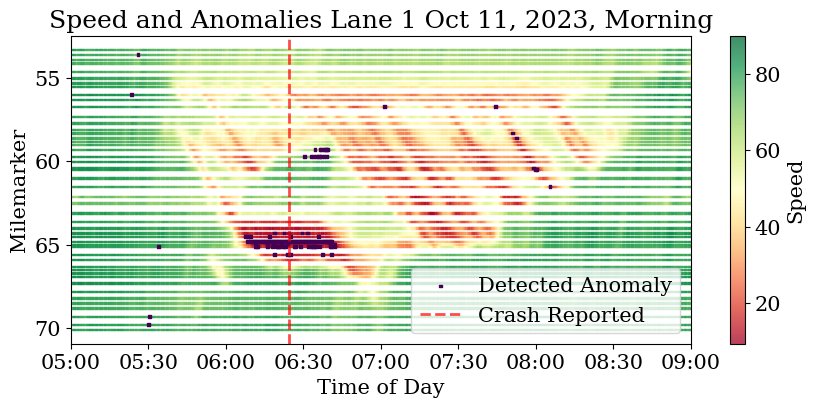

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/nomanual_anom_results_gat.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index']*30+ 14400, unit='s') 
plt.figure(figsize=(10,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed'].values),marker='s',s=1, cmap='viridis')
scatter = plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values*80,marker='s',s=1, cmap='RdYlGn', alpha=0.75)
colorbar = plt.colorbar(scatter, label='Speed (mph)')
filtered_lane = lane[lane['Anomaly'] == 1]

plt.scatter(filtered_lane['Time Index'], filtered_lane['Milemarker'].values,
            c=filtered_lane['Anomaly'].values, marker='s', s=4, cmap='viridis', label='Detected Anomaly', alpha=1)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Speed and Anomalies Lane 1 Oct 11, 2023, Morning")
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.axvline(x=crash_reported, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.7)
plt.xlim(start_time, end_time)
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.legend(loc='lower right')
plt.show()

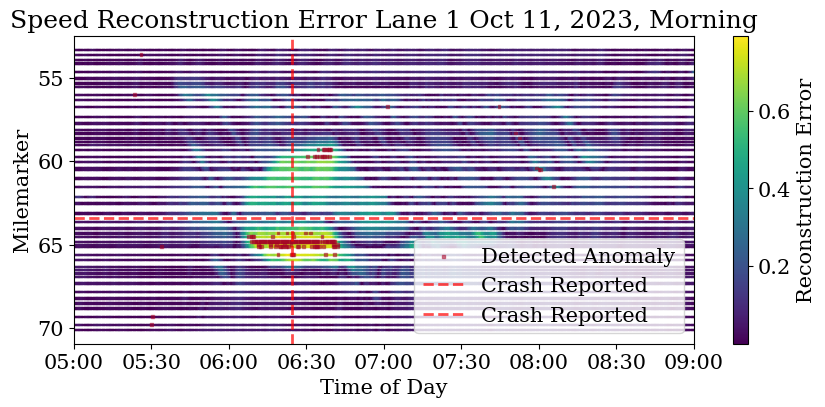

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/nomanual_anom_results_gat.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index']*30+ 14400, unit='s') 
plt.figure(figsize=(10,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
scatter = plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=np.abs(lane['Reconstructed Speed'].values-lane['Speed'].values),marker='s',s=1, cmap='viridis')
colorbar = plt.colorbar(scatter, label='Reconstruction Error')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn', alpha=0.75)
filtered_lane = lane[lane['Anomaly'] == 1]

plt.scatter(filtered_lane['Time Index'], filtered_lane['Milemarker'].values,
            c=filtered_lane['Anomaly'].values, marker='s', s=4, cmap='RdYlGn', label='Detected Anomaly', alpha=0.5)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Speed Reconstruction Error Lane 1 Oct 11, 2023, Morning")
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.axvline(x=crash_reported, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.7)
plt.xlim(start_time, end_time)
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.legend(loc='lower right')
plt.show()